<a href="https://colab.research.google.com/github/yagamishi/cython/blob/main/%E2%80%9Cgeek_bang_chap07_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club
---

Here we document our experiment with lending club data set.


In [1]:
import numpy as np

In [ ]:
!wget https://storage.googleapis.com/open_data_file/final.zip

--2021-08-20 05:12:47--  https://storage.googleapis.com/open_data_file/final.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2021-08-20 05:12:47 ERROR 403: Forbidden.



In [2]:
!ls

sample_data


In [ ]:
!unzip final.zip

unzip:  cannot find or open final.zip, final.zip.zip or final.zip.ZIP.


In [3]:
import os
 
print(os.getcwd())
 
 
# 修改工作路径
import os
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/Colab "+"Notebooks/homework2"
os.chdir(path)


/content
Mounted at /content/gdrive


In [4]:
import pandas as pd
train = pd.read_csv(path+"/train_final.csv", engine='python')
test = pd.read_csv(path+"/test_final.csv", engine='python')

In [5]:
print(train.shape)
test.shape

(50000, 146)


(50000, 146)

In [ ]:
# 检查空值
pd.isnull(train['loan_status']).sum()

0

In [ ]:
# 检查训练集y值
train['loan_status'].value_counts()

1    39788
0    10212
Name: loan_status, dtype: int64

In [ ]:
# 检查测试集y值
test['loan_status'].value_counts()

1    40226
0     9774
Name: loan_status, dtype: int64

In [ ]:
# 列出continuous开头的列字段
[x for x in train.columns.to_list() if x.startswith('continuous')]

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec']

In [ ]:
# 看分位数
train['continuous_funded_amnt'].describe()

count    50000.00000
mean     14332.53650
std       8617.58487
min       1000.00000
25%       7775.00000
50%      12000.00000
75%      20000.00000
max      35000.00000
Name: continuous_funded_amnt, dtype: float64

In [ ]:
# 查看更细的分位数,可以看到35%和40%是一样的，那就有可能有衍生变量
train['continuous_funded_amnt'].describe(percentiles=np.arange(0, 1, 0.05))

count    50000.00000
mean     14332.53650
std       8617.58487
min       1000.00000
0%        1000.00000
5%        3000.00000
10%       4800.00000
15%       5500.00000
20%       6300.00000
25%       7775.00000
30%       8500.00000
35%      10000.00000
40%      10000.00000
45%      11600.00000
50%      12000.00000
55%      14000.00000
60%      15000.00000
65%      16000.00000
70%      18000.00000
75%      20000.00000
80%      21000.00000
85%      24000.00000
90%      28000.00000
95%      32000.00000
max      35000.00000
Name: continuous_funded_amnt, dtype: float64

In [ ]:
pd.isnull(train['continuous_funded_amnt']).sum()

0

In [ ]:
# 查看continuous_loan_amnt和y值是不是有关系
train[['loan_status', 'continuous_funded_amnt']].groupby('loan_status').describe(percentiles=np.arange(0, 1, 0.1))

continuous_funded_amnt                ...                  
                             count          mean  ...      90%      max
loan_status                                       ...                  
0                          10212.0  15622.400118  ...  28000.0  35000.0
1                          39788.0  14001.479718  ...  27200.0  35000.0

[2 rows x 15 columns]

In [ ]:
# 前面说的10000特别特殊,现在开始检验。生成新变量
train['discrete_is_loan_10000'] = (train['continuous_funded_amnt']==10000).astype(np.int64)

In [ ]:
train['discrete_is_loan_10000'].value_counts()

0    46323
1     3677
Name: discrete_is_loan_10000, dtype: int64

In [ ]:
# 离散数据用列联表，借款10000的违约的比较大。0--》1:4，1--〉1：5。loan_status：0是违约，1是不违约
pd.crosstab(train['discrete_is_loan_10000'],train['loan_status'])

loan_status,0,1
discrete_is_loan_10000,,
0,9590,36733
1,622,3055


In [112]:
# 下面开始baseline了
# 这个命令是shuffle
train_new = train.sample(frac=1)

In [ ]:
# 查看shuffle是否成功
train.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,discrete_is_loan_10000
0,55000.0,NaN,0.0,5.91,NaN,679.0,675.0,3600.0,3600.0,1.0,123.03,13.99,564.0,560.0,3600.0,1,30.0,30.0,NaN,7.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,65000.0,NaN,1.0,16.06,NaN,719.0,715.0,24700.0,24700.0,4.0,820.28,11.99,699.0,695.0,24700.0,1,6.0,NaN,NaN,22.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,63000.0,71000.0,0.0,10.78,13.85,699.0,695.0,20000.0,20000.0,0.0,432.66,10.78,704.0,700.0,20000.0,1,NaN,NaN,NaN,6.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,104433.0,NaN,1.0,25.37,NaN,699.0,695.0,10400.0,10400.0,3.0,289.91,22.45,704.0,700.0,10400.0,1,12.0,NaN,NaN,12.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,34000.0,NaN,0.0,10.20,NaN,694.0,690.0,11950.0,11950.0,0.0,405.18,13.44,759.0,755.0,11950.0,1,NaN,NaN,NaN,5.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train_new.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,discrete_is_loan_10000
47569,23000.0,NaN,0.0,16.81,NaN,709.0,705.0,1600.0,1600.0,0.0,52.38,10.99,739.0,735.0,1600.0,1,NaN,NaN,NaN,6.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
34975,65000.0,NaN,1.0,8.83,NaN,664.0,660.0,10000.0,10000.0,1.0,325.69,10.64,539.0,535.0,10000.0,0,22.0,53.0,34.0,16.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
18245,43680.0,NaN,2.0,20.66,NaN,684.0,680.0,8875.0,8875.0,1.0,291.49,11.22,594.0,590.0,8875.0,0,14.0,NaN,NaN,14.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
20373,53000.0,NaN,1.0,38.99,NaN,699.0,695.0,15000.0,15000.0,1.0,510.27,13.67,664.0,660.0,15000.0,1,19.0,NaN,NaN,10.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
49652,45000.0,NaN,0.0,8.31,NaN,664.0,660.0,12000.0,12000.0,0.0,395.66,11.49,764.0,760.0,12000.0,1,44.0,45.0,13.0,8.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
train_new.to_csv("train_new.csv", index=False)

In [ ]:
len(train_new.columns.to_list())

147

In [6]:
# baseline开始了
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import torch

import copy
cpu_count = 4
use_gpu = False
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    num_leaves: any = hp.choice('num_leaves', [64])
    metric: any = hp.choice('metric', ['binary_error'])
    num_round: any = hp.choice('num_rounds', [1000])
    objective: any = hp.choice('objective', ['binary'])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [7]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")

In [8]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

In [9]:
fitter = LGBFitter(label='loan_status')

In [165]:
# 重新读取，前面代码多加了一列
import pandas as pd
train = pd.read_csv(path+"/train_final.csv", engine='python')
test = pd.read_csv(path+"/test_final.csv", engine='python')
train_new = train.sample(frac=1)
train_new.to_csv("train_new.csv", index=False)
# 正确的应该是146
len(train_new.columns.to_list())

146

In [166]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
for num_leaves in [6]:
    params = {'num_thread': 4, 'num_leaves': num_leaves, 'metric': 'binary', 'objective': 'binary','
                'num_round': 4000, 'learning_rate': 0.0075, 'feature_fraction': 0.8,
           'bagging_fraction': 0.8}
    # 这里用train_new,用train一般会高，所以要用shuffle
    train_pred, test_pred, error_rate, models = fitter.train_k_fold(kfold, train_new, test, params = params)
print(params)
print('各模型误差',error_rate)
print('平均误差',np.mean(error_rate))
# 查看测试集的结果
print('测试集误差',1 - accuracy_score(test['loan_status'], (test_pred > 0.5).astype(np.int64)))


The minimum is attained in round 3125
The minimum is attained in round 1502
The minimum is attained in round 2802
The minimum is attained in round 3100
The minimum is attained in round 2139
{'num_thread': 4, 'num_leaves': 6, 'metric': 'binary', 'objective': 'binary', 'boosting': 'goss', 'num_round': 4000, 'learning_rate': 0.0075, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
各模型误差 [0.07189999999999996, 0.08009999999999995, 0.0826, 0.08330000000000004, 0.07989999999999997]
平均误差 0.07955999999999999
测试集误差 0.08204


In [ ]:
pip install thermoencoder

In [ ]:
pip install category_encoders

In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(train_add.drop(columns='loan_status')) # This will take some time

In [ ]:
x = train_add.drop(columns='loan_status')
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x.iloc[0,:])

In [167]:
# 重新读取，前面代码多加了一列
import pandas as pd
train = pd.read_csv(path+"/train_final.csv", engine='python')
test = pd.read_csv(path+"/test_final.csv", engine='python')
train_new = train.sample(frac=1)
train_new.to_csv("train_new.csv", index=False)
# 正确的应该是146
len(train_new.columns.to_list())
# 下面开始加变量
# 合并（把train和test一起加一列，一起做了，不然要做2次，最后拆开就好了）
TRAIN_INDEX = train_new.shape[0]
TEST_INDEX = test.shape[0] + TRAIN_INDEX


In [168]:
data = pd.concat([train_new, test], axis=0)

In [169]:
data.shape

(100000, 146)

In [ ]:
data['continuous_last_fico_range_high'].describe(percentiles=np.arange(0, 1, 0.05))

In [86]:
# 这个变量其实是没用的，因为分箱了,lightgbm本来就是分箱的，所以加一个10000的参数是无用。
# data['discrete_is_loan_10000'] = data['continuous_last_fico_range_high'].mean()

In [170]:
# We can find the most important variables in the following ways.
features = train_new.drop(columns='loan_status').columns.to_list()
importance = models[0].feature_importance(importance_type = 'gain')
# print(importance)
feautre_importance = sorted(zip(features, importance), key = lambda x : x[1], reverse=True)
print(feautre_importance)

[('continuous_last_fico_range_high', 1401772.897958517), ('continuous_last_fico_range_low', 217284.48886084557), ('discrete_term_1_one_hot', 59170.122960567474), ('continuous_dti', 37164.984292030334), ('continuous_funded_amnt', 31120.287940979004), ('continuous_installment', 29918.86306166649), ('continuous_fico_range_high', 22163.562014102936), ('continuous_annual_inc', 21347.18479537964), ('continuous_mths_since_last_delinq', 21004.87567138672), ('continuous_int_rate', 20945.384246110916), ('continuous_open_acc', 18462.52542090416), ('continuous_funded_amnt_inv', 14237.623793125153), ('discrete_emp_length_12_one_hot', 13679.375308513641), ('continuous_mths_since_last_major_derog', 11516.99791932106), ('discrete_term_2_one_hot', 10980.366670370102), ('continuous_mths_since_last_record', 9893.039208650589), ('continuous_fico_range_low', 4566.433777093887), ('continuous_inq_last_6mths', 4434.754617929459), ('discrete_home_ownership_1_one_hot', 2716.9062983989716), ('discrete_purpose_1_

In [171]:
print(data['continuous_last_fico_range_high'])

4799     769.0
12233    539.0
10924    764.0
46633    769.0
276      579.0
         ...  
49995    734.0
49996    524.0
49997    669.0
49998    719.0
49999    719.0
Name: continuous_last_fico_range_high, Length: 100000, dtype: float64


In [275]:
temp = data['continuous_last_fico_range_high'].value_counts().to_dict()
print(temp)

{694.0: 3133, 704.0: 3105, 719.0: 3092, 724.0: 3086, 709.0: 3080, 689.0: 3033, 699.0: 3017, 684.0: 3006, 714.0: 2999, 734.0: 2681, 499.0: 2656, 729.0: 2653, 679.0: 2612, 674.0: 2437, 739.0: 2268, 669.0: 2231, 744.0: 2221, 664.0: 2024, 754.0: 1879, 749.0: 1821, 659.0: 1699, 759.0: 1692, 654.0: 1565, 769.0: 1517, 764.0: 1473, 649.0: 1347, 779.0: 1346, 644.0: 1293, 774.0: 1270, 784.0: 1204, 634.0: 1179, 554.0: 1086, 639.0: 1086, 789.0: 1079, 574.0: 1055, 564.0: 1052, 544.0: 1043, 794.0: 1038, 559.0: 1037, 584.0: 1025, 579.0: 1014, 624.0: 1014, 569.0: 1001, 614.0: 974, 539.0: 956, 534.0: 935, 549.0: 931, 629.0: 921, 594.0: 917, 609.0: 916, 604.0: 915, 599.0: 906, 799.0: 904, 589.0: 883, 619.0: 866, 804.0: 840, 524.0: 821, 529.0: 801, 809.0: 720, 519.0: 715, 514.0: 673, 509.0: 604, 814.0: 590, 504.0: 562, 819.0: 542, 824.0: 340, 829.0: 272, 834.0: 179, 839.0: 87, 844.0: 52, 850.0: 23, 0.0: 6}


In [276]:
data['continuous_last_fico_range_high_couts'] = data['continuous_last_fico_range_high'].map(temp)

In [277]:
data.columns.to_list()

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'loan_status',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec',
 'discrete_addr_state_1_one_hot',
 'discrete_addr_state_2_one_hot',
 'discrete_addr_state_3_one_hot',
 'discrete_addr_state_4_one_hot',
 'discrete_addr_state_5_one_hot',
 'discrete_addr_state_6_one_hot',
 'discrete_addr_state_7_one_hot',
 'discrete_addr_state_8_one_hot',
 'discrete_addr_state_9_one_hot',
 'discrete_addr_state_10_one_hot',
 'discrete_addr_state_11_one_hot',
 'discrete_addr_s

In [278]:
data.shape

(100000, 147)

In [279]:
# 拆开
train_add = data.iloc[0:TRAIN_INDEX, :]
test_add = data.iloc[TRAIN_INDEX:TEST_INDEX, :]
train_add.shape

(50000, 147)

In [178]:
test_add.shape

(50000, 147)

In [194]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
for bagging_fraction in [1.0, 0.8, 0.7, 0.5, 0.4, 0.3]:
    params = {'num_thread': 4, 'num_leaves': 4, 'metric': 'binary', 'objective': 'binary',
                'num_round': 3000, 'learning_rate': 0.0075, 'feature_fraction': 0.8,
           'bagging_fraction': bagging_fraction}
    #  这里用train_add
    train_pred, test_pred, error_rate, models = fitter.train_k_fold(kfold, train_add, test_add, params = params)
    print(params)
    print(np.mean(error_rate))
    print(1 - accuracy_score(test_add['loan_status'], (test_pred > 0.5).astype(np.int64)))

The minimum is attained in round 2644
The minimum is attained in round 2876
The minimum is attained in round 2939
The minimum is attained in round 2996
The minimum is attained in round 2161
{'num_thread': 4, 'num_leaves': 4, 'metric': 'binary', 'objective': 'binary', 'num_round': 3000, 'learning_rate': 0.0075, 'feature_fraction': 0.8, 'bagging_fraction': 1.0}
0.07949999999999997
0.08264000000000005
The minimum is attained in round 2644
The minimum is attained in round 2876
The minimum is attained in round 2939
The minimum is attained in round 2996
The minimum is attained in round 2161
{'num_thread': 4, 'num_leaves': 4, 'metric': 'binary', 'objective': 'binary', 'num_round': 3000, 'learning_rate': 0.0075, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
0.07949999999999997
0.08264000000000005
The minimum is attained in round 2644
The minimum is attained in round 2876
The minimum is attained in round 2939
The minimum is attained in round 2996
The minimum is attained in round 2161
{'num_

# Stacking



In [202]:
pip install catboost

In [208]:
pip install utils

In [300]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn import linear_model

In [301]:
# X_data = Train_data.drop('price', axis=1) #删除列
X_data = train_add.drop(columns='loan_status')
Y_data = train_add['loan_status']
X_test  = test_add.drop(columns='loan_status')

In [302]:
#定义模型
def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=4,n_estimators = 3000)
    param_grid = {
        # 'learning_rate': [0.0075],
        'num_leaves': 4,
        'metric': 'binary', 
        'objective': 'binary', 
        'num_round': 3000, 
        'learning_rate': 0.0075, 
        'feature_fraction': 0.8, 
        'bagging_fraction': 0.8
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

In [303]:
#交叉验证
#划分训练集和测试集
X_data=pd.DataFrame(X_data).fillna(-1)
Y_data=pd.DataFrame(Y_data).fillna(-1)
X_test=pd.DataFrame(X_test).fillna(-1)
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

#训练模型
print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)



Predict GBDT...


KeyboardInterrupt: ignored

In [297]:
subA_gbdt = model_gbdt.predict(X_test)

In [298]:
print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

predict XGB...
[11:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [299]:
print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

predict lgb...


ValueError: ignored

In [243]:
#Starking
#第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred
Strak_X_train['Method_3'] = train_gbdt_pred

Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb
Strak_X_val['Method_3'] = val_gbdt

Strak_X_test = pd.DataFrame()
Strak_X_test['Method_1'] = subA_lgb
Strak_X_test['Method_2'] = subA_xgb
Strak_X_test['Method_3'] = subA_gbdt

In [290]:
#第二层
model_lr_Stacking = build_model_lgb(Strak_X_train,y_train)
train_lgb_pred_y = model_lr_Stacking.predict(Strak_X_train)
print(1 - accuracy_score(y_train['loan_status'], (train_lgb_pred_y > 0.5).astype(np.int64)))

# #训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print(1 - accuracy_score(y_train['loan_status'], (train_pre_Stacking > 0.5).astype(np.int64)))
# print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

# #验证集
# val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
# print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

# #预测集
# print('Predict Stacking-LR...')
# subA_Stacking = model_lr_Stacking.predict(Strak_X_test)


0.08605714285714283


# Why it doesn't work?
---
In LigthGBM, the algorithm will automatically create binnings. In this case, since about 10% of the "loan amount" is exactly $10000, it will automatically fall into a bin. Therefore, adding the additional data will not work.  

In [115]:
# We can find the most important variables in the following ways.
features = train_new.drop(columns='loan_status').columns.to_list()
importance = models[0].feature_importance(importance_type = 'gain')
# print(importance)
feautre_importance = sorted(zip(features, importance), key = lambda x : x[1], reverse=True)
print(feautre_importance)

[6.65184672e+03 7.21707010e+00 1.18339314e+03 1.57761869e+04
 2.53335690e+02 7.17213447e+03 1.74402112e+03 1.71171757e+04
 1.18503906e+04 1.81346271e+03 1.09091043e+04 6.17728762e+03
 1.27041784e+06 2.60077710e+05 1.38542367e+03 7.39806283e+03
 3.27635631e+03 4.74320199e+03 5.55124015e+03 3.83817910e+02
 4.29163601e+01 0.00000000e+00 5.95496682e+02 5.16357059e+02
 9.41730022e+00 8.43172014e+00 1.23258500e+01 4.31559700e+02
 3.19684441e+02 1.20804601e+01 7.78411891e+01 4.74001389e+02
 1.57237711e+02 2.31666821e+02 3.39957442e+02 4.59587169e+02
 2.06811889e+02 2.08178980e+02 1.98170180e+02 1.13859799e+01
 1.50773750e+02 6.98274493e+01 3.30169951e+02 1.08052171e+02
 4.34809899e+02 0.00000000e+00 2.28272420e+02 2.28136497e+01
 5.18220299e+01 0.00000000e+00 2.20102301e+01 1.42404669e+02
 9.60802798e+01 5.53182403e+01 8.02860950e+02 1.97647910e+02
 8.28609579e+02 3.95716000e+00 1.65993410e+02 2.49791020e+02
 0.00000000e+00 0.00000000e+00 1.84192900e+02 2.35271001e+00
 8.43264093e+01 3.110285

# SHAP and force plots
---
In this code snippet, we demonstrate the process of using SHAP values and force plots to examine the cause of bad cases. Additional information can be found [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html).

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 15.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491650 sha256=d1f93269ce7bcb3c2aabce9cde98c9caa048b596edbb5b5c95e8abadeb0cd1bc
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import shap
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(train_add.drop(columns='loan_status')) # This will take some time

KeyError: ignored

In [ ]:
x = train_add.drop(columns='loan_status')
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x.iloc[0,:])


# Learning a Bayesian Network
---
This small example demonstrates how to create a Bayesian Network using R. Pay attention that it is usually desirable to input discretized data! 

In [48]:
%load_ext rpy2.ipython

In [49]:
%%R
install.packages("bnlearn")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/bnlearn_4.6.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1287342 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [50]:
%%R
library(bnlearn)

In [51]:
%%R
data(marks)

In [52]:
%%R
summary(marks)

      MECH            VECT            ALG             ANL       
 Min.   : 0.00   Min.   : 9.00   Min.   :15.00   Min.   : 9.00  
 1st Qu.:30.00   1st Qu.:42.00   1st Qu.:45.00   1st Qu.:35.75  
 Median :41.50   Median :51.00   Median :50.00   Median :49.00  
 Mean   :38.95   Mean   :50.59   Mean   :50.60   Mean   :46.68  
 3rd Qu.:49.25   3rd Qu.:60.00   3rd Qu.:57.25   3rd Qu.:57.00  
 Max.   :77.00   Max.   :82.00   Max.   :80.00   Max.   :70.00  
      STAT      
 Min.   : 9.00  
 1st Qu.:31.00  
 Median :40.00  
 Mean   :42.31  
 3rd Qu.:51.50  
 Max.   :81.00  


In [53]:
%%R
bn.gs = gs(marks)

In [54]:
%%R
bn.gs


  Bayesian network learned via Constraint-based methods

  model:
    [undirected graph]
  nodes:                                 5 
  arcs:                                  6 
    undirected arcs:                     6 
    directed arcs:                       0 
  average markov blanket size:           2.40 
  average neighbourhood size:            2.40 
  average branching factor:              0.00 

  learning algorithm:                    Grow-Shrink 
  conditional independence test:         Pearson's Correlation 
  alpha threshold:                       0.05 
  tests used in the learning procedure:  80 



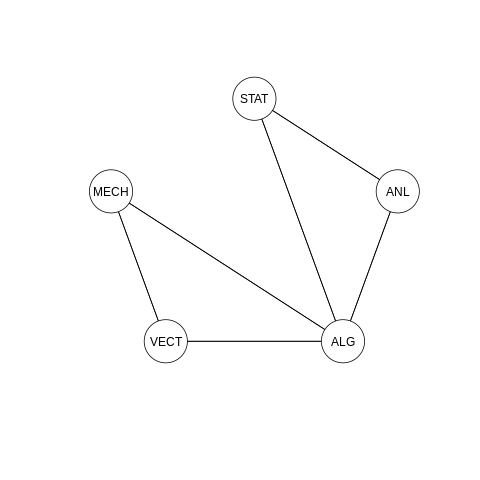

In [55]:
%%R
plot(bn.gs)